In [1]:
# Import list
import numpy as np
import pandas as pd
import os
import time
import itertools

os.chdir('../..')
import AstroPack as AP
os.chdir('./hyperparameter_tuning/logg')

from matplotlib import rc
rc('text', usetex=True)

from sklearn.model_selection import train_test_split

%matplotlib inline

# Getting the data

In [ ]:
# Create a list of the columns that will be used
column_list = ['TILE_ID', 'NUMBER', 'teff', 'teff_err', 'logg', 'logg_err', 'feh', 'feh_err'] + AP.Filters['JPLUS'] + AP.Filters['WISE'] + AP.Filters['GAIA']

# Import the full dataframe with stars that have both JPLUS, WISE and LAMOST data
os.chdir('../../data')
stars_raw = pd.read_csv('STEPEs Input Data.csv', usecols=column_list)
os.chdir('../hyperparameter_tuning/logg')

# Drop any row with missing values from the dataframe
stars_raw = stars_raw.dropna()

# Filter the stars according to their parameter errors
stars_raw = stars_raw[stars_raw['teff_err'] <= 300]
stars_raw = stars_raw[stars_raw['logg_err'] <= 0.2]
stars_raw = stars_raw[stars_raw['feh_err'] <= 0.4]

In [ ]:
# Convert it into a dataframe with magnitudes and colors, indexed by the TILE ID and NUMBER of the star
stars_raw, stars = AP.AssembleWorkingDF(stars_raw, addWISE=True, addGALEX=False, addGAIA=True, Colors=True, Combinations=False)
logg = stars_raw['logg']

# Random Forest CV - logg

In [6]:
# Split the full sample into training and test samples
x_develop, x_test, y_develop, y_test = train_test_split(stars, logg, test_size=0.25, random_state=42)

In [7]:
# Create lists with the values of each hyperparameter that will be tested
n_features = [15, 45, 60, 190]
n_trees = [50, 100]
min_samples_leaf = [1, 10]
max_features = [0.25, 0.5, 0.75, 'auto']
criterion = ["mse"]

# Create a list containing every possible combination of hyperparameters
HPCombinations = [item for item in itertools.product(n_features, n_trees, min_samples_leaf, max_features, criterion)]

In [10]:
# Loop through all the hyperparameter combinations
for HPCombination in HPCombinations:
    # By doing a 4-fold, 2-repeat cross-validation, calculate the average value and the standard deviation of the error metrics 
    # and elapsed time for a model initizalized with the hyperparameter combination
    Metrics = AP.rf_evaluator(HPCombination, x_develop, y_develop, n_splits = 4, n_repeats = 2, verbose = 1)
    
    # Save the hyperparameter combination and the evaluation results to a csv file        
    pd.DataFrame(data=(HPCombination + Metrics)).T.to_csv('rf_logg_tuning.csv', mode='a', index = False, header = False)

Starting Random Forest 4-Fold, 2 repeat CV with: n_features = 190, n_trees = 100, min_samples_leaf = 1 , max_features = auto, criterion = mse...
Current Fold: 1/8
Current Fold: 2/8
Current Fold: 3/8
Current Fold: 4/8
Current Fold: 5/8
Current Fold: 6/8
Current Fold: 7/8
Current Fold: 8/8
CV Process Finished! Results:
Mean Absolute Error: 0.117 (0.001)
Root Mean Squared Error: 0.180  (0.003)
Max Error: 2.558 (0.472)
R2 Score: 0.874 (0.004)
Time Elapsed: 1021.043 (76.252) s


Starting Random Forest 4-Fold, 2 repeat CV with: n_features = 190, n_trees = 100, min_samples_leaf = 10 , max_features = 0.25, criterion = mse...
Current Fold: 1/8
Current Fold: 2/8
Current Fold: 3/8
Current Fold: 4/8
Current Fold: 5/8
Current Fold: 6/8
Current Fold: 7/8
Current Fold: 8/8
CV Process Finished! Results:
Mean Absolute Error: 0.119 (0.001)
Root Mean Squared Error: 0.179  (0.002)
Max Error: 2.118 (0.235)
R2 Score: 0.875 (0.002)
Time Elapsed: 212.539 (9.033) s


Starting Random Forest 4-Fold, 2 repeat CV 

# Graphical Analysis

In [2]:
hp_tuning_rf = pd.read_csv('rf_logg_tuning.csv')

x_axis = {'max_features': ['0.25', '0.5', '0.75', 'auto']}
y_axis = {'n_features': [190, 60, 45, 15]}

In [3]:
t_50_l_1_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 50, 'min_samples_leaf': 1}, x_axis, y_axis, 'R2')
t_100_l_1_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 100, 'min_samples_leaf': 1}, x_axis, y_axis, 'R2')
t_50_l_10_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 50, 'min_samples_leaf': 10}, x_axis, y_axis, 'R2')
t_100_l_10_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 100, 'min_samples_leaf': 10}, x_axis, y_axis, 'R2')

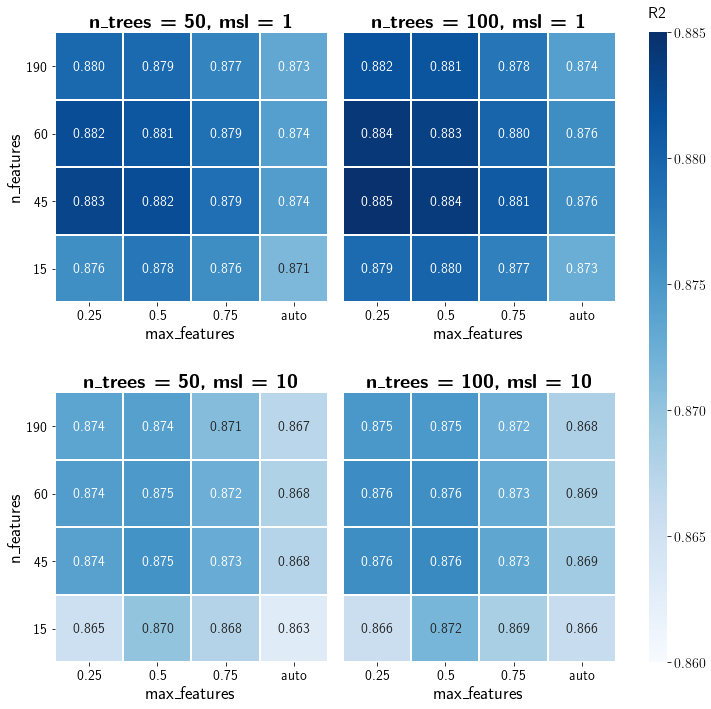

In [4]:
figure = AP.plot_heatmaps(t_50_l_1_matrix, r'\textbf{n\_trees = 50, msl = 1}',  
                          t_50_l_10_matrix, r'\textbf{n\_trees = 50, msl = 10}',
                          t_100_l_1_matrix, r'\textbf{n\_trees = 100, msl = 1}',
                          t_100_l_10_matrix, r'\textbf{n\_trees = 100, msl = 10}', 
                          x_label = 'max\_features', y_label = 'n\_features',
                          value_format = '.3f', cmap = 'Blues', v_min = 0.86, v_max = 0.885, 
                          colorbar_label='R2', colorbar_ticks = 6)

figure.savefig('rf_logg_R2_heatmap.jpg', dpi = 250)

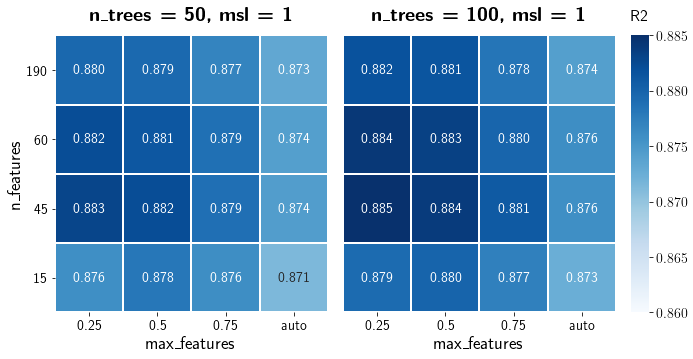

In [5]:
figure = AP.plot_heatmaps_single_line(t_50_l_1_matrix, r'\textbf{n\_trees = 50, msl = 1}',
                                      t_100_l_1_matrix, r'\textbf{n\_trees = 100, msl = 1}', 
                                      x_label = 'max\_features', y_label = 'n\_features',
                                      value_format = '.3f', cmap = 'Blues', v_min = 0.86, v_max = 0.885, 
                                      colorbar_label='R2', colorbar_ticks = 6)

figure.savefig('rf_logg_R2_heatmap (msl = 1).jpg', dpi = 250)

In [6]:
t_50_l_1_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 50, 'min_samples_leaf': 1}, x_axis, y_axis, 'Time').astype(int)
t_100_l_1_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 100, 'min_samples_leaf': 1}, x_axis, y_axis, 'Time').astype(int)
t_50_l_10_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 50, 'min_samples_leaf': 10}, x_axis, y_axis, 'Time').astype(int)
t_100_l_10_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 100, 'min_samples_leaf': 10}, x_axis, y_axis, 'Time').astype(int)

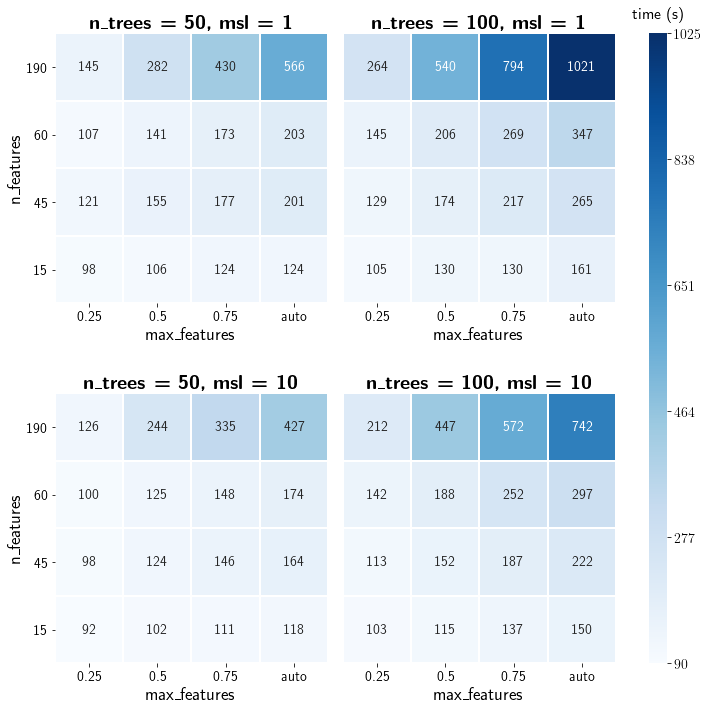

In [7]:
figure = AP.plot_heatmaps(t_50_l_1_matrix, r'\textbf{n\_trees = 50, msl = 1}',  
                          t_50_l_10_matrix, r'\textbf{n\_trees = 50, msl = 10}',
                          t_100_l_1_matrix, r'\textbf{n\_trees = 100, msl = 1}',
                          t_100_l_10_matrix, r'\textbf{n\_trees = 100, msl = 10}', 
                          x_label = 'max\_features', y_label = 'n\_features',
                          value_format = 'd', cmap = 'Blues', v_min = 90, v_max = 1025, 
                          colorbar_label='time (s)', colorbar_ticks = 6)

figure.savefig('rf_logg_time_heatmap.jpg', dpi = 250)

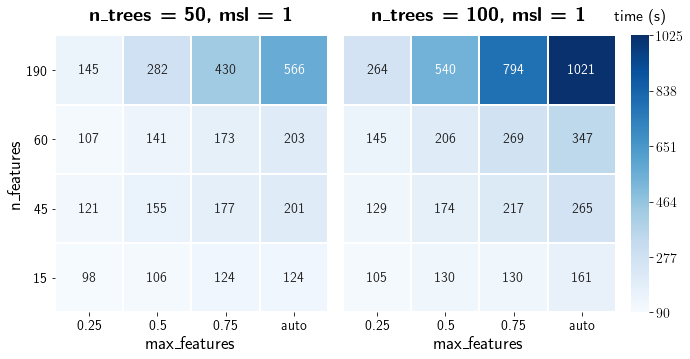

In [8]:
figure = AP.plot_heatmaps_single_line(t_50_l_1_matrix, r'\textbf{n\_trees = 50, msl = 1}',
                                      t_100_l_1_matrix, r'\textbf{n\_trees = 100, msl = 1}',
                                      x_label = 'max\_features', y_label = 'n\_features', 
                                      value_format = 'd', cmap = 'Blues', v_min = 90, v_max = 1025, 
                                      colorbar_label='time (s)', colorbar_ticks = 6)

figure.savefig('rf_logg_time_heatmap (msl = 1).jpg', dpi = 250)